In [22]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data68632


In [23]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [24]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

mkdir: cannot create directory ‘/home/aistudio/external-libraries’: File exists
Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 122kB 12.4MB/s eta 0:00:01


In [25]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

In [26]:
import numpy as np
import matplotlib.pyplot as plt

In [27]:
def load_data():
    # 从文件导入数据
    datafile = './data/data68632/housing.csv'
    data = np.fromfile(datafile, sep=' ')

    # 每条数据包括14项，其中前面13项是影响因素，第14项是相应的房屋价格中位数

    feature_num = 14

    # 将原始数据进行Reshape，变成[N, 14]这样的形状
    data = data.reshape([data.shape[0] // feature_num, feature_num])

    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    # 测试集和训练集必须是没有交集的
    ratio = 0.8
    feature=data
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]

    # 计算训练集的最大值，最小值，平均值
    maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0), \
                                 training_data.sum(axis=0) / training_data.shape[0]

    # 对数据进行归一化处理
    for i in range(feature_num):
        #print(maximums[i], minimums[i], avgs[i])
        data[:, i] = (data[:, i] - minimums[i]) / (maximums[i] - minimums[i])

    # 训练集和测试集的划分比例
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data,test_data,minimums[13],maximums[13]

In [28]:
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        # np.random.seed(0)
        self.w1 = np.random.randn(num_of_weights, num_of_weights)
        self.b1= 0.
        self.w2 = np.random.randn(num_of_weights, 1)
        self.b2 = 0.

    def forward(self, x):
        z1 = np.dot(x, self.w1) + self.b1
        z1relu=np.maximum(z1,0)
        z =np.dot(z1relu,self.w2) + self.b2
        return z,z1relu,z1

    def loss(self, z, y):

        error = z - y

        num_samples = error.shape[0]
        cost = error * error
        cost = np.sum(cost) / num_samples
        return cost

    def gradient(self, x, y):
        z,z1relu,z1= self.forward(x)
        N = x.shape[0]
        gradient_w1 = 1. / N * np.sum((z - y) * z1relu * x, axis=0)
        gradient_w1 = gradient_w1[:, np.newaxis]
        gradient_b1 = 1. / N * np.sum((z - y)*(y-z1relu))
        gradient_w2 = 1. / N * np.sum((z - y) * z1relu, axis=0)
        gradient_w2 = gradient_w2[:, np.newaxis]
        gradient_b2 = 1. / N * np.sum(z - y)
        return gradient_w1, gradient_b1,gradient_w2,gradient_b2

    def update(self, gradient_w1, gradient_b1,gradient_w2 ,gradient_b2,eta=0.01):
        self.w1 = self.w1 - eta * gradient_w1
        self.b1 = self.b1 - eta * gradient_b1
        self.w2 = self.w2 - eta * gradient_w2
        self.b2 = self.b2 - eta * gradient_b2
    def train(self, training_data, num_epochs, batch_size=10, eta=0.01):
        n = len(training_data)
        losses = []
        for epoch_id in range(num_epochs):
            # 在每轮迭代开始之前，将训练数据的顺序随机打乱
            # 然后再按每次取batch_size条数据的方式取出
            np.random.shuffle(training_data)
            # 将训练数据进行拆分，每个mini_batch包含batch_size条的数据
            mini_batches = [training_data[k:k + batch_size] for k in range(0, n, batch_size)]
            for iter_id, mini_batch in enumerate(mini_batches):
                # print(self.w.shape)
                # print(self.b)
                x = mini_batch[:, :-1]
                y = mini_batch[:, -1:]
                a ,a1,a2= self.forward(x)
                loss = self.loss(a, y)
                gradient_w1, gradient_b1,gradient_w2,gradient_b2 = self.gradient(x, y)
                self.update(gradient_w1, gradient_b1,gradient_w2,gradient_b2, eta)
                losses.append(loss)
                print('Epoch {:3d} / iter {:3d}, loss = {:.4f}'.
                      format(epoch_id, iter_id, loss))

        return losses


Epoch   0 / iter   0, loss = 11.8691
Epoch   0 / iter   1, loss = 2.6153
Epoch   0 / iter   2, loss = 2.7220
Epoch   0 / iter   3, loss = 1.3440
Epoch   0 / iter   4, loss = 0.3506
Epoch   1 / iter   0, loss = 1.3944
Epoch   1 / iter   1, loss = 0.7274
Epoch   1 / iter   2, loss = 0.4148
Epoch   1 / iter   3, loss = 0.8300
Epoch   1 / iter   4, loss = 0.1580
Epoch   2 / iter   0, loss = 0.5554
Epoch   2 / iter   1, loss = 0.6380
Epoch   2 / iter   2, loss = 0.2867
Epoch   2 / iter   3, loss = 0.3996
Epoch   2 / iter   4, loss = 0.0993
Epoch   3 / iter   0, loss = 0.4571
Epoch   3 / iter   1, loss = 0.5723
Epoch   3 / iter   2, loss = 0.4078
Epoch   3 / iter   3, loss = 0.3883
Epoch   3 / iter   4, loss = 0.3289
Epoch   4 / iter   0, loss = 0.7743
Epoch   4 / iter   1, loss = 0.3767
Epoch   4 / iter   2, loss = 0.4063
Epoch   4 / iter   3, loss = 0.2566
Epoch   4 / iter   4, loss = 0.5815
Epoch   5 / iter   0, loss = 0.4219
Epoch   5 / iter   1, loss = 0.5180
Epoch   5 / iter   2, loss 

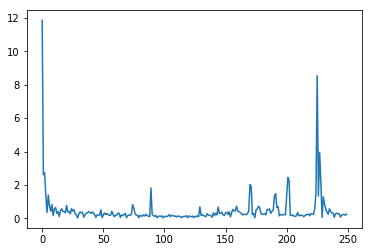

In [29]:
# 获取数据
train_data, test_data,min,max= load_data()

# 创建网络
net = Network(13)
# 启动训练
losses = net.train(train_data, num_epochs=50, batch_size=100, eta=0.1)

# 画出损失函数的变化趋势
plot_x = np.arange(len(losses))
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()

In [30]:
x=test_data[-10,-1]
pred,pred1,pred2=net.forward(test_data[-10,:-1])
repred=(pred*max)-(min*(pred-1))
retest=(x*max)-(min*(x-1))
print("取倒数第十行数据测试实际值为",retest,"预测值为",repred)

取倒数第十行数据测试实际值为 19.7 预测值为 [-2.82325999]
